In [26]:
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-12.2'

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import seaborn as sns
import time
# from skimage import io
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import accuracy_score
import cv2
from tensorflow.keras.utils import plot_model

In [2]:
folder_path = f"run/flip/x/DenseNet169Adamax0.0001_Freeze80AkhirV2/"
patch_folder =  "patchingFlip/patchingFlipX_4/"
# patch_folder =  "patchingDatasetBiasa_4/"
# patch_folder =  "patching_4/"
# patch_folder =  "patchingRotate270_4/"



os.makedirs(folder_path, exist_ok=True)

In [3]:
class_names = ['CLL', 'FL', 'MCL']


In [4]:
images = []
labels = []
targets = []
patch_image_CLL = []
patch_image_FL = []
patch_image_MCL = []
patch_label = []
main_image_CLL = []
main_image_FL = []
main_image_MCL = []
main_label = []

final_patch_image = []
final_patch_label = []

final_main_image = []
final_main_label = []


for label_index, folder_name in enumerate(sorted(os.listdir(patch_folder))):
    folder_path = os.path.join(patch_folder, folder_name)
    if os.path.isdir(folder_path):
        for image_name in sorted(os.listdir(folder_path)):
            if image_name.lower().endswith('.tif'):
                image_path = os.path.join(folder_path, image_name)
                image = cv2.imread(image_path)
                image = image / 255.0
                # image = np.transpose(image, (1, 0, 2))
                height, width, channels = image.shape
                if folder_name == 'CLL':
                    patch_image_CLL.append(image)
                elif folder_name == 'FL':
                    patch_image_FL.append(image)
                elif folder_name == 'MCL':
                    patch_image_MCL.append(image)
                patch_label.append(label_index)
                
patch_image_CLL = [patch_image_CLL[i:i+16] for i in range(0, len(patch_image_CLL), 16)]
patch_image_FL = [patch_image_FL[i:i+16] for i in range(0, len(patch_image_FL), 16)]
patch_image_MCL = [patch_image_MCL[i:i+16] for i in range(0, len(patch_image_MCL), 16)]

In [5]:
print(len(patch_image_MCL))

244


In [6]:
final_patch_image = patch_image_CLL + patch_image_FL + patch_image_MCL
final_patch_label = [patch_label[i] for i in range(0, len(patch_label), 16)]

In [7]:
final_patch_image = np.array(final_patch_image)
final_patch_label = np.array(final_patch_label)

In [8]:
print(len(final_patch_image))
print(len(final_patch_label))

748
748


In [9]:
final_patch_image.shape

(748, 16, 260, 347, 3)

In [10]:
x_train,x_test,y_train,y_test = train_test_split(final_patch_image,final_patch_label,test_size = 0.3,stratify=final_patch_label,random_state=42)
x_val,x_test,y_val,y_test = train_test_split(x_test,y_test,test_size = 0.5,stratify=y_test,random_state=42)
# x_train,x_test,y_train,y_test = train_test_split(final_patch_image,final_patch_label,test_size = 0.3,random_state = 42)
# x_val,x_test,y_val,y_test = train_test_split(x_test,y_test,test_size = 0.5,random_state = 42)

In [11]:
y_testVoting = y_test
x_testVoting = x_test
x_testVoting.shape

(113, 16, 260, 347, 3)

In [12]:
print("Unique labels in y_testVoting:", np.unique(y_testVoting))
# y_testVoting -= 1
print("Unique labels in y_testVoting:", np.unique(y_testVoting))

Unique labels in y_testVoting: [0 1 2]
Unique labels in y_testVoting: [0 1 2]


In [13]:
print("Unique labels in y_testVoting:", np.unique(y_test))
# y_test -= 1
print("Unique labels in y_testVoting:", np.unique(y_test))

Unique labels in y_testVoting: [0 1 2]
Unique labels in y_testVoting: [0 1 2]


In [14]:
x_train = x_train.reshape(-1, 260, 347, 3)
x_val = x_val.reshape(-1, 260, 347, 3)
x_test = x_test.reshape(-1, 260,347,3)
y_train = np.repeat(y_train, 16)
y_val = np.repeat(y_val, 16)
y_test = np.repeat(y_test,16)

# x_train = x_train.reshape(-1, 520, 694, 3)
# x_val = x_val.reshape(-1, 520, 694, 3)
# x_test = x_test.reshape(-1, 520,694,3)
# y_train = np.repeat(y_train, 4)
# y_val = np.repeat(y_val, 4)
# y_test = np.repeat(y_test,4)

In [15]:
print(f"x train shapee : {x_train.shape}")
print(f"x val shapee : {x_val.shape}")
print(f"x test shapee : {x_test.shape}")

x train shapee : (8368, 260, 347, 3)
x val shapee : (1792, 260, 347, 3)
x test shapee : (1808, 260, 347, 3)


In [16]:
print(f"y train shapee : {y_train.shape}")
print(f"y val shapee : {y_val.shape}")
print(f"y test shapee : {y_test.shape}")

y train shapee : (8368,)
y val shapee : (1792,)
y test shapee : (1808,)


In [109]:
learning_rate = 0.0001
epochs = 100
batch_size = 16
height = 260
width = 347
# channels = 3
# height = 520
# width = 694

In [18]:
from tensorflow.keras.applications import DenseNet169, Xception, ResNet50, EfficientNetB0, DenseNet201, DenseNet121
from tensorflow.keras.optimizers import Adagrad, Adamax, Adam
import tensorflow as tf


base_model = DenseNet169(
    weights='imagenet', 
    include_top=False, 
    input_shape=(height,width,channels),
)

# num_layers_to_train = int(np.ceil(0.2 * len(base_model.layers)))
# print(f'panjang layer asli : {len(base_model.layers)}')
# print(f'panjang layer freeze : {num_layers_to_train}')

# Membekukan 50% layer awal
# for layer in base_model.layers[:num_layers_to_train]:
#     layer.trainable = False

# membekukan 50% layer di akhir
# for layer in base_model.layers[num_layers_to_train:] :
#     layer.trainable = False

# for layer in base_model.layers:
#     layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


# Optimizer
model.compile(optimizer=Adamax(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Rangkuman model
model.summary()

# from tensorflow.keras.utils import plot_model

# plot_model(model, to_file='ResNet50.png', show_shapes=True, show_layer_names=True)


2025-01-10 19:34:08.424912: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 36591 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 7g.40gb, pci bus id: 0000:07:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 260, 347, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 266, 353, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 130, 174, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 130, 174, 64)         256       ['conv1/conv[0][0]']      

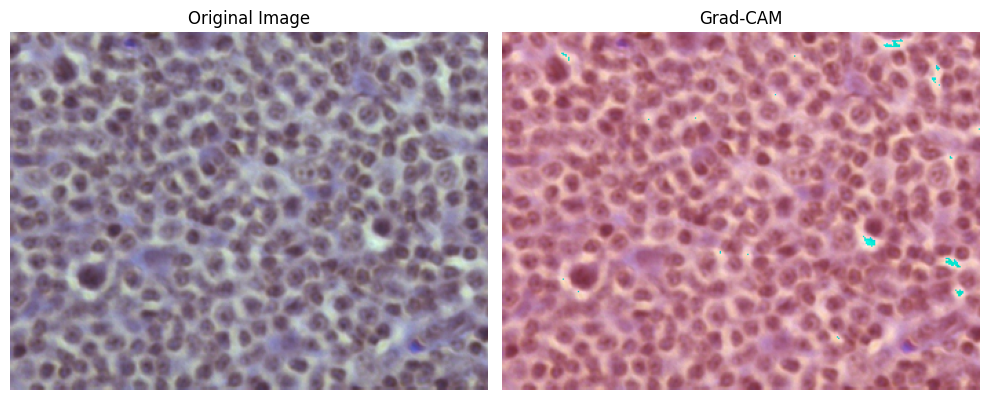

In [111]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.models import load_model

# folder_path = f"run/flip/x/DenseNet169Adamax/"
folder_path = f"run/flip/x/DenseNet169Adamax0.0001_Freeze80AkhirV2/"
model = load_model(f'{folder_path}best_modelAdamax.h5')


height = 260
width = 347

folder_pathXAI = f"XAI/Grad-Cam/TestTime/"
os.makedirs(folder_pathXAI, exist_ok=True)

last_conv_layer_name = "conv5_block32_concat"  # Sesuaikan jika berbeda
last_conv_layer = model.get_layer(last_conv_layer_name)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Buat model grad-CAM
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Hitung gradien
    grads = tape.gradient(class_channel, conv_outputs)

    # Rata-rata gradien secara spasial
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Dapatkan output feature map
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()

    # Timbang channel dari conv_outputs dengan gradien yang dihitung
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    # Rata-rata sepanjang channel untuk dapatkan heatmap
    heatmap = np.mean(conv_outputs, axis=-1)

    # ReLU
    heatmap = np.maximum(heatmap, 0)
    # Normalisasi
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)

    return heatmap

# img_path = 'incorrect_predictions/original_imageFixModel_556.png'
img_path = 'correct_predictionsTimeModel/original_imageTimeModel_CLL_1724.png'


def load_and_preprocess_image(img_path, target_size=(height,width)):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    # Jika diperlukan normalisasi sama dengan yang digunakan saat training:
    # x = x/255.0 atau sesuai normalisasi yang dipakai saat training
    return img, x

original_img, preprocessed_img = load_and_preprocess_image(img_path)

# Dapatkan heatmap
heatmap = make_gradcam_heatmap(preprocessed_img, model, last_conv_layer_name)


def display_gradcam(original_img, heatmap, alpha=0.4):
    # Konversi heatmap ke 0-255
    heatmap = np.uint8(255 * heatmap)
    # Terapkan colormap
    
    heatmap = cv2.resize(heatmap, (original_img.size[0], original_img.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    original_img_array = image.img_to_array(original_img)

    # Overlay heatmap ke gambar asli
    overlay = heatmap * alpha + original_img_array

    # Tampilkan hasil
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(original_img)
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(np.uint8(overlay))
    ax[1].set_title("Grad-CAM")
    ax[1].axis('off')
    plt.tight_layout()
    save_path = os.path.join(folder_pathXAI, "TestTrue1724.png")
    fig.savefig(save_path)
    plt.show()
    

display_gradcam(original_img, heatmap)


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Asumsi: model sudah didefinisikan dan diload sebelumnya, misal:
# model = ... # Model Anda

# Parameter gambar
height = 260
width = 347

# Buat folder untuk menyimpan hasil jika diperlukan
folder_pathXAI = "XAI/Saliency/"
os.makedirs(folder_pathXAI, exist_ok=True)

def load_and_preprocess_image(img_path, target_size=(height,width)):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    # Normalisasi jika diperlukan, misalnya:
    # x = x / 255.0
    return img, x

# def make_saliency_map(img_array, model):
#     # Gunakan GradientTape untuk merekam gradien input terhadp output kelas prediksi tertinggi
#     with tf.GradientTape() as tape:
#         tape.watch(img_array)
#         predictions = model(img_array)
#         pred_index = tf.argmax(predictions[0])
#         loss = predictions[:, pred_index]

#     # Hitung gradien
#     grads = tape.gradient(loss, img_array)
    
#     # Ambil nilai absolut gradien (saliency)
#     saliency = tf.abs(grads)
#     # Ambil nilai maksimum sepanjang channel
#     saliency = tf.reduce_max(saliency, axis=-1)
#     saliency = saliency[0].numpy()

#     # Normalisasi saliency map ke [0,1]
#     saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-10)
#     return saliency

def make_saliency_map(img_array, model):
    # Pastikan img_array adalah tf.Tensor
    img_array = tf.convert_to_tensor(img_array)
    
    with tf.GradientTape() as tape:
        tape.watch(img_array)
        predictions = model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, img_array)
    saliency = tf.abs(grads)
    saliency = tf.reduce_max(saliency, axis=-1)
    saliency = saliency[0].numpy()

    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-10)
    return saliency

def display_saliency_map(original_img, saliency_map):
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(original_img)
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    # Tampilkan saliency map dengan colormap 'jet' untuk visualisasi
    ax[1].imshow(saliency_map, cmap='jet')
    ax[1].set_title("Saliency Map")
    ax[1].axis('off')
    plt.tight_layout()

    # Simpan hasil jika diinginkan
    save_path = os.path.join(folder_pathXAI, "saliency_map_output.png")
    fig.savefig(save_path)
    plt.show()

# Contoh penggunaan
img_path = "run/CLL_image1_flipX_sub_image_0_0.tif"  # Ganti dengan path gambar Anda
original_img, preprocessed_img = load_and_preprocess_image(img_path)

# preprocessed_img = tf.convert_to_tensor(preprocessed_img)
saliency = make_saliency_map(preprocessed_img, model)
display_saliency_map(original_img, saliency)


In [28]:
from sklearn.metrics import classification_report, confusion_matrix ,multilabel_confusion_matrix


def grafik(y_pred,y_test,class_names):
    folder_path = f"run/flip/x/DenseNet169Adamax/"
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(os.path.join(folder_path, f"cm_plot_patchingAdamax2.png"))
    plt.show()


    # loss = hist.history['loss']
    # val_loss = hist.history['val_loss']

    # plt.plot(loss, 'b', label='Training loss')
    # plt.plot(val_loss, 'r', label='Validation loss')
    # plt.title('Training and Validation Loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.savefig(os.path.join(folder_path, f"loss_plot_patchingAdamax.png"))
    # plt.show()

    
    # acc = hist.history['accuracy']
    # val_acc = hist.history['val_accuracy']
    # plt.plot(acc, 'b', label='Training acc')
    # plt.plot(val_acc, 'r', label='Validation acc')
    # plt.title('Training and Validation Accuracy')
    # plt.xlabel('Epochs')
    # plt.ylabel('Accuracy')
    # plt.legend(loc = 'lower right')
    # plt.savefig(os.path.join(folder_path, f"accuracy_plot_patchingAdamax.png"))
    # plt.show()

In [20]:

print("Unique labels in y_train:", np.unique(y_train))
print("Unique labels in y_val:", np.unique(y_val))
print("Unique labels in y_test:", np.unique(y_test))


Unique labels in y_train: [0 1 2]
Unique labels in y_val: [0 1 2]
Unique labels in y_test: [0 1 2]


In [91]:
y_train -= 1
y_val -= 1
# # y_test -= 1

In [21]:

print("Unique labels in y_train:", np.unique(y_train))
print("Unique labels in y_val:", np.unique(y_val))
# print("Unique labels in y_test:", np.unique(y_test))


Unique labels in y_train: [0 1 2]
Unique labels in y_val: [0 1 2]


In [22]:
#### Callback (simpan model terbaik, menyimpan hasil training ke csv, dan early stop)
folder_path = f"run/flip/x/DenseNet169AdamaxV3/"

model_checkpoint = ModelCheckpoint(os.path.join(folder_path, f"best_modelAdamax.h5"), monitor='val_loss', save_best_only=True,verbose = 1)
csv_logger = CSVLogger(os.path.join(folder_path, f"logAdamax.csv"), separator=',', append=False)
# early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Hitung waktu training
start_time = time.time()

# Training
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[model_checkpoint, csv_logger],
    batch_size=batch_size,
)

# Hitung waktu training
end_time = time.time()

# Menampilkan lama proses training
print(f"Training Time : {end_time - start_time}")

Epoch 1/100


2025-01-10 19:35:00.291151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2025-01-10 19:35:01.453753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-01-10 19:35:01.471592: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f282b593e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-10 19:35:01.471656: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 7g.40gb, Compute Capability 8.0
2025-01-10 19:35:01.476625: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-10 19:35:01.534045: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-01-10 19:3

523/523 [==============================] - ETA: 0s - loss: 0.3507 - accuracy: 0.8648
Epoch 1: val_loss improved from inf to 0.11103, saving model to run/flip/x/DenseNet169AdamaxV3/best_modelAdamax.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


523/523 [==============================] - 128s 124ms/step - loss: 0.3507 - accuracy: 0.8648 - val_loss: 0.1110 - val_accuracy: 0.9604
Epoch 2/100
523/523 [==============================] - ETA: 0s - loss: 0.0950 - accuracy: 0.9681
Epoch 2: val_loss improved from 0.11103 to 0.07054, saving model to run/flip/x/DenseNet169AdamaxV3/best_modelAdamax.h5
523/523 [==============================] - 54s 103ms/step - loss: 0.0950 - accuracy: 0.9681 - val_loss: 0.0705 - val_accuracy: 0.9760
Epoch 3/100
523/523 [==============================] - ETA: 0s - loss: 0.0535 - accuracy: 0.9827
Epoch 3: val_loss improved from 0.07054 to 0.05498, saving model to run/flip/x/DenseNet169AdamaxV3/best_modelAdamax.h5
523/523 [==============================] - 52s 99ms/step - loss: 0.0535 - accuracy: 0.9827 - val_loss: 0.0550 - val_accuracy: 0.9799
Epoch 4/100
523/523 [==============================] - ETA: 0s - loss: 0.0416 - accuracy: 0.9867
Epoch 4: val_loss did not improve from 0.05498
523/523 [=============

In [29]:
from tensorflow.keras.models import load_model
folder_path = f"run/flip/x/DenseNet169Adamax/"
model = load_model(f'{folder_path}best_modelAdamax.h5')

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

y_pred = np.round(y_pred)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# classification_rep = classification_report(y_test, y_pred, target_names=class_names, digits=4)
# print("Classification Report:\n", classification_rep)

# grafik(y_pred,y_test,class_names)

57/57 [==============================] - 5s 41ms/step
Accuracy: 100.00%
Classification Report:
               precision    recall  f1-score   support

         CLL     1.0000    1.0000    1.0000       544
          FL     1.0000    1.0000    1.0000       672
         MCL     1.0000    1.0000    1.0000       592

    accuracy                         1.0000      1808
   macro avg     1.0000    1.0000    1.0000      1808
weighted avg     1.0000    1.0000    1.0000      1808



NameError: name 'grafik' is not defined

In [30]:
from tensorflow.keras.models import load_model

folder_path = f"run/flip/x/DenseNet169Adamax/"
# folder_path = f"run/oriDataset/ResNet50_2/"
# model = load_model(f'{folder_path}best_modelAdam.h5')
model = load_model(f'{folder_path}best_modelAdamax.h5')

voting_result = []
for all_image in x_testVoting:
    hasil = model.predict(all_image)
    #print("Hasil :", hasil)
    predicted_labels = tf.argmax(hasil, axis=1).numpy()
    print("Predicted Labels :", predicted_labels)
    arrMody = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predicted_labels)
    arrMody = arrMody.reshape(-1, 1)
    Final = arrMody.flatten()
    voting_result.append(Final[0])

voting_result = np.array(voting_result)

print(f"\n true label : ")
print(y_testVoting)

print(f"\n voting label : ")
print(voting_result)

score = accuracy_score(voting_result, y_testVoting)
print(score)

classification_rep = classification_report(y_testVoting, voting_result, target_names=class_names, digits=4)
print("Classification Report:\n", classification_rep)

1/1 [==============================] - 3s 3s/step
Predicted Labels : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1/1 [==============================] - 0s 95ms/step
Predicted Labels : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
1/1 [==============================] - 0s 77ms/step
Predicted Labels : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1/1 [==============================] - 0s 93ms/step
Predicted Labels : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
1/1 [==============================] - 0s 55ms/step
Predicted Labels : [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
1/1 [==============================] - 0s 49ms/step
Predicted Labels : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1/1 [==============================] - 0s 91ms/step
Predicted Labels : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1/1 [==============================] - 0s 68ms/step
Predicted Labels : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
1/1 [==============================] - 0s 88ms/step
Predicted Labels : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1/1 [==============================] - 0s 99ms/step
Predi

In [ ]:
x_test.shape, y_test.shape, y_pred.shape

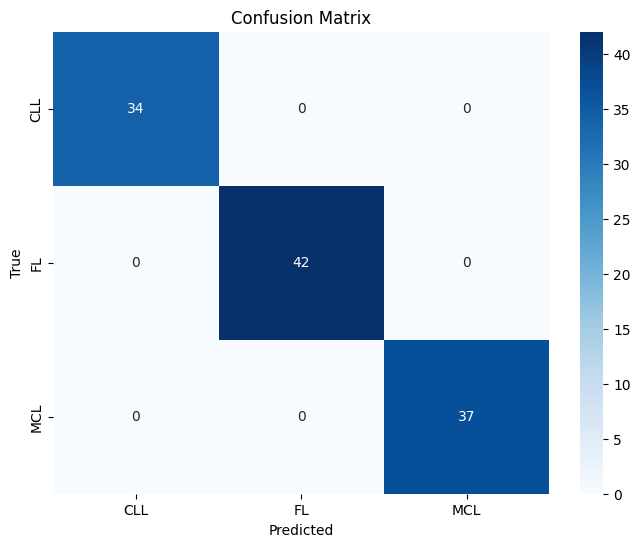

In [17]:
from sklearn.metrics import classification_report, confusion_matrix ,multilabel_confusion_matrix

folder_path = f"run/evalAfterCombine/FIXMODEL/"

cm = confusion_matrix(y_testVoting, voting_result)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(os.path.join(folder_path, f"cm_plot_votingFIXMODEL.png"))
plt.show()

In [27]:
from tensorflow.keras.models import load_model
folder_path = f"run/flip/x/DenseNet169Adamax0.0001_Freeze80AkhirV2/"
# folder_path = f"run/flip/x/DenseNet169Adamax0.0001_Freeze80AkhirV2/"
model = load_model(f'{folder_path}best_modelAdamax.h5')

y_pred_proba = model.predict(x_test)
y_pred = np.argmax(y_pred_proba, axis=1)

y_pred = np.round(y_pred)
class_map = {name: idx for idx, name in enumerate(class_names)}

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

classification_rep = classification_report(y_test, y_pred, target_names=class_names, digits=4)
print("Classification Report:\n", classification_rep)


57/57 [==============================] - 4s 37ms/step
Accuracy: 99.94%
Classification Report:
               precision    recall  f1-score   support

         CLL     1.0000    0.9982    0.9991       544
          FL     1.0000    1.0000    1.0000       672
         MCL     0.9983    1.0000    0.9992       592

    accuracy                         0.9994      1808
   macro avg     0.9994    0.9994    0.9994      1808
weighted avg     0.9994    0.9994    0.9994      1808



In [18]:
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

dic = {0:"CLL", 1:"FL", 2:"MCL"}

In [19]:
x_test.shape, y_test.shape, y_pred.shape

((1808, 260, 347, 3), (1808,), (1808,))

In [20]:
test_patch_image = x_test.reshape(113, 16, 260, 347, 3)
test_patch_label = y_test.reshape(113,-1)
pred_patch_label = y_pred.reshape(113,-1)


In [21]:
test_patch_image.shape, test_patch_label.shape, pred_patch_label.shape

((113, 16, 260, 347, 3), (113, 16), (113, 16))

In [22]:
test_voting_result = []
pred_voting_result = []
for all_label in test_patch_label:
    arrMody = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=all_label)
    arrMody = arrMody.reshape(-1, 1)
    Final = arrMody.flatten()
    test_voting_result.append(Final[0])

for all_label in pred_patch_label:
    arrMody = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=all_label)
    arrMody = arrMody.reshape(-1, 1)
    Final = arrMody.flatten()
    pred_voting_result.append(Final[0])

In [23]:
accuracy_voting = accuracy_score(test_voting_result, pred_voting_result)
print(f"Accuracy Voting: {accuracy_voting * 100:.2f}%")

Accuracy Voting: 100.00%


In [24]:
for index, (test, pred) in enumerate(zip(test_voting_result, pred_voting_result)):
    if test!=pred:
        print(f"Index yang salah adalah {index} dengan test:{test} & pred:{pred}")
    else:
        continue

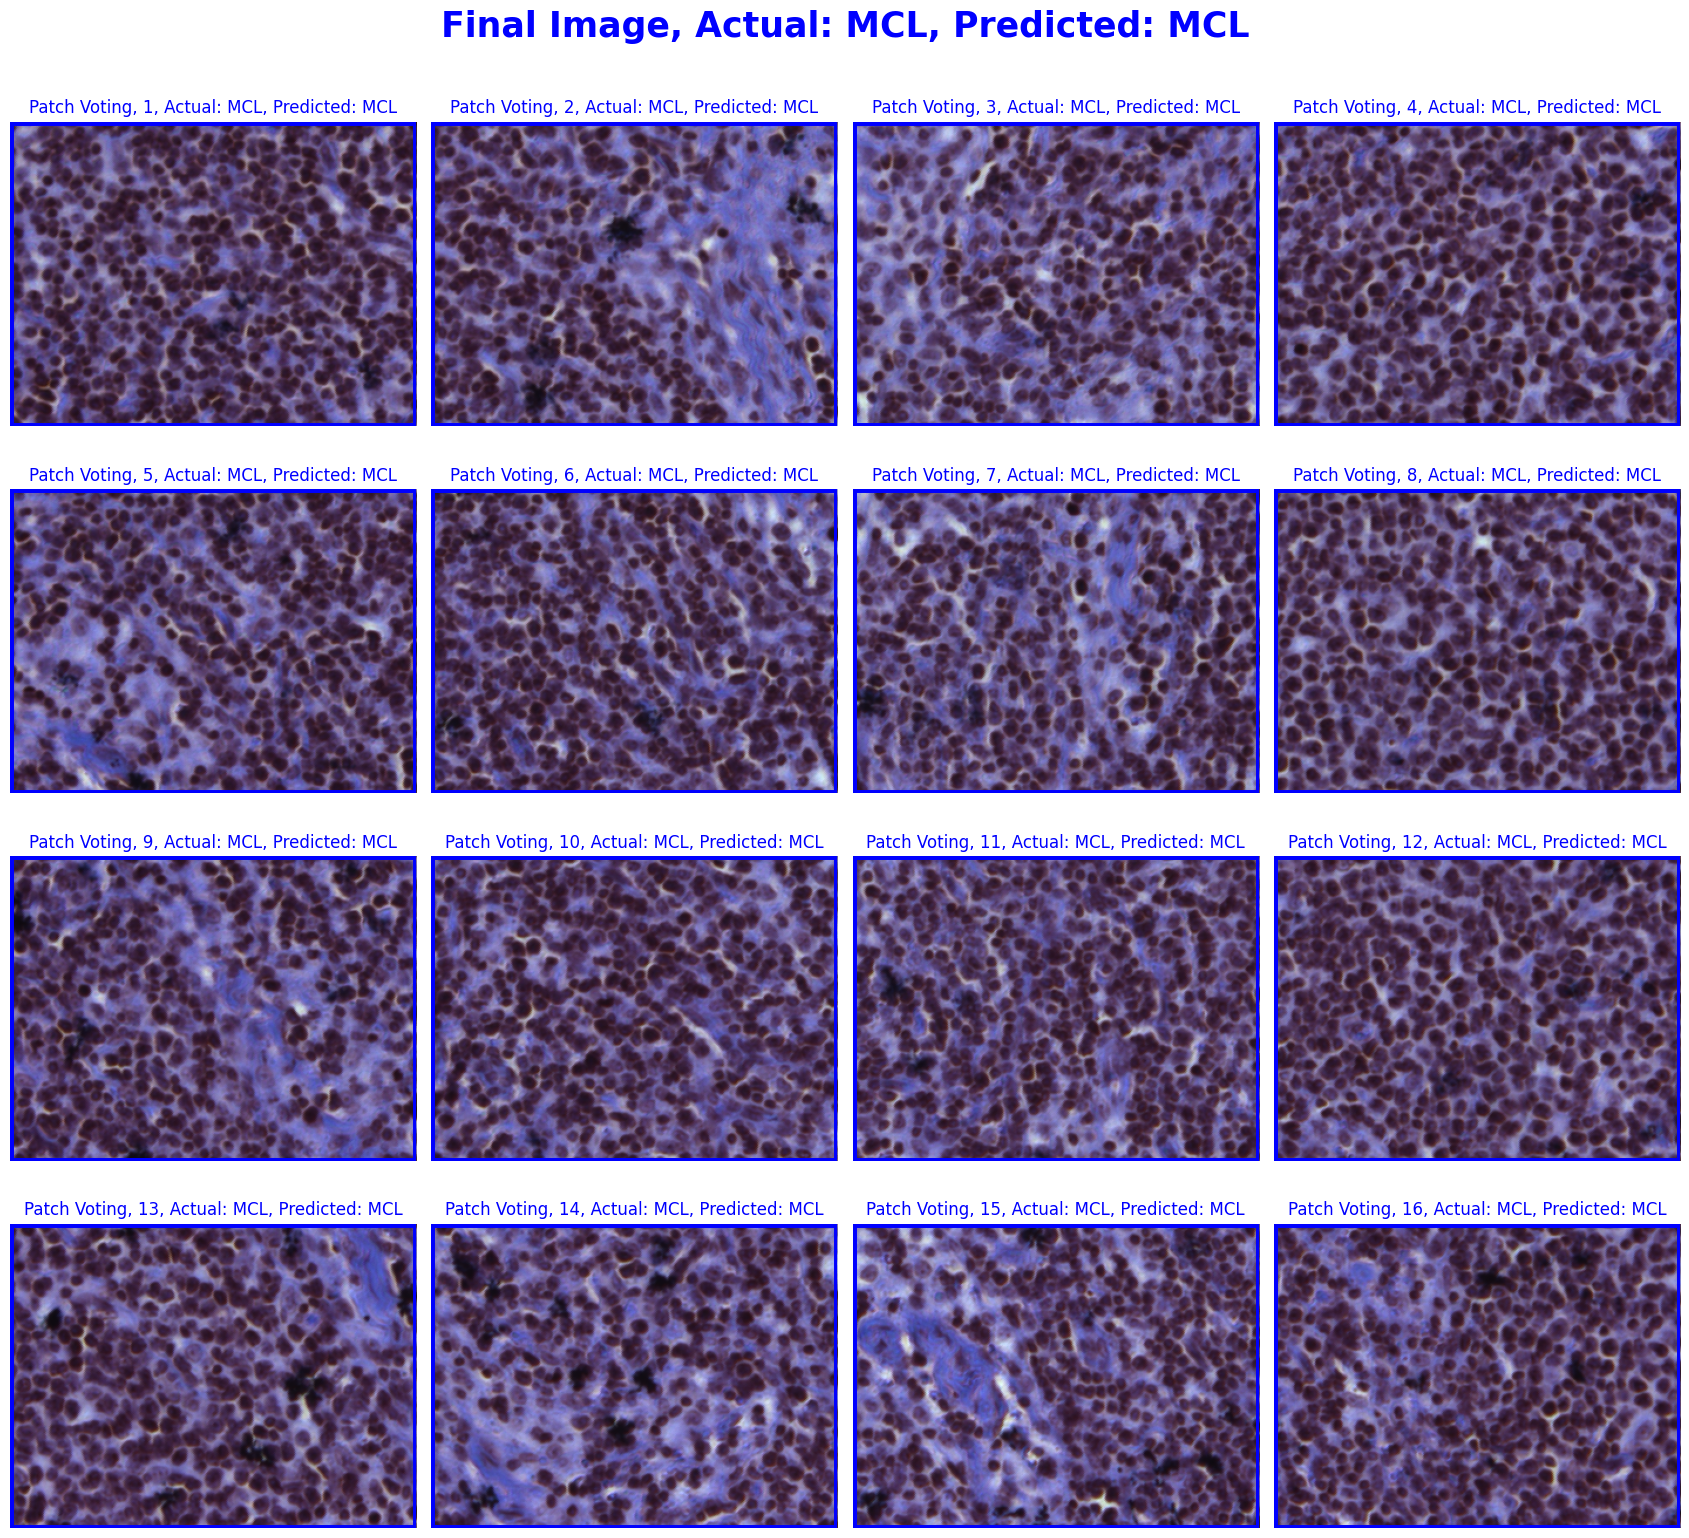

In [25]:
import matplotlib.patches as patches
fig, axes = plt.subplots(4, 4, figsize=(17, 17))
index_target = 4
sup_color = "red" if pred_voting_result[index_target] != test_voting_result[index_target] else "blue"
folder_path2 = f"MajorEvalFix/"

for i, ax in enumerate(axes.flat):
    actual = test_patch_label[index_target][i]
    predicted = pred_patch_label[index_target][i]
    if actual != predicted:
        title_color = "red"
        border_color = "red"
    else:
        title_color = "blue"
        border_color = "blue"
    
    ax.imshow(test_patch_image[index_target][i])
    rect = patches.Rectangle(
        (0, 0), 1, 1,
        linewidth=5, edgecolor=border_color, facecolor="none", transform=ax.transAxes
    )
    ax.add_patch(rect)
    ax.axis("off")
    ax.set_title(f"Patch Voting, {i+1}, Actual: {dic[test_patch_label[index_target][i]]}, Predicted: {dic[pred_patch_label[index_target][i]]}", color=title_color)

fig.suptitle(f"Final Image, Actual: {dic[test_voting_result[index_target]]}, Predicted: {dic[pred_voting_result[index_target]]}", fontsize=25, fontweight='bold', color=sup_color, y=0.93)
plt.tight_layout(rect=[0, 0, 1, 0.93])
fig.savefig(os.path.join(folder_path2, f'TestMajor'))
plt.show()

In [28]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.patches as patches

folder_path = f"run/flip/x/DenseNet169Adamax/"
model = load_model(f'{folder_path}best_modelAdamax.h5')

# Predicting the classes
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Rounding the predictions
y_pred = np.round(y_pred)

# Accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

classification_rep = classification_report(y_test, y_pred, target_names=class_names, digits=4)
print("Classification Report:\n", classification_rep)

# Function to display the incorrect images with border
def display_incorrect_predictions(x_test, y_test, y_pred, class_names):
    incorrect_indices = np.where(y_test != y_pred)[0]  # Find indices where the prediction is incorrect
    print(f"Total Incorrect Predictions: {len(incorrect_indices)}")
    
    # Loop through and display incorrect predictions with border
    for index in incorrect_indices:
        fig, ax = plt.subplots(figsize=(5, 5))
        
        # Get actual and predicted values
        actual = y_test[index]
        predicted = y_pred[index]
        
        # Set border color based on the prediction correctness
        if actual != predicted:
            title_color = "red"
            border_color = "red"
        else:
            title_color = "blue"
            border_color = "blue"
        
        # Display image
        ax.imshow(x_test[index])
        
        # Add border rectangle around the image
        rect = patches.Rectangle(
            (0, 0), 1, 1,
            linewidth=5, edgecolor=border_color, facecolor="none", transform=ax.transAxes
        )
        ax.add_patch(rect)
        
        # Set title and remove axis
        ax.set_title(f"True: {class_names[actual]}\nPred: {class_names[predicted]}", color=title_color)
        ax.axis('off')
        
        # Display the image with border
        plt.tight_layout()
        plt.show()

# Call the function to display incorrect predictions
display_incorrect_predictions(x_test, y_test, y_pred, class_names)


57/57 [==============================] - 4s 38ms/step
Accuracy: 100.00%
Classification Report:
               precision    recall  f1-score   support

         CLL     1.0000    1.0000    1.0000       544
          FL     1.0000    1.0000    1.0000       672
         MCL     1.0000    1.0000    1.0000       592

    accuracy                         1.0000      1808
   macro avg     1.0000    1.0000    1.0000      1808
weighted avg     1.0000    1.0000    1.0000      1808

Total Incorrect Predictions: 0


In [59]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.patches as patches
import os

folder_path = f"run/flip/x/DenseNet169Adamax0.0001_Freeze80AkhirV2/"
model = load_model(f'{folder_path}best_modelAdamax.h5')

# Predicting the classes
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Rounding the predictions
y_pred = np.round(y_pred)

# Accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

classification_rep = classification_report(y_test, y_pred, target_names=class_names, digits=4)
print("Classification Report:\n", classification_rep)

# Function to display and save the incorrect images with border
def display_and_save_incorrect_predictions(x_test, y_test, y_pred, class_names, save_folder="incorrect_predictionsTimeModel"):
    incorrect_indices = np.where(y_test != y_pred)[0]  # Find indices where the prediction is incorrect
    print(f"Total Incorrect Predictions: {len(incorrect_indices)}")
    
    # Create the folder to save images if it doesn't exist
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    
    # Loop through and display incorrect predictions with border
    for index in incorrect_indices:
        fig, ax = plt.subplots(figsize=(5, 5))
        
        # Get actual and predicted values
        actual = y_test[index]
        predicted = y_pred[index]
        
        # Set border color based on the prediction correctness
        if actual != predicted:
            title_color = "red"
            border_color = "red"
        else:
            title_color = "blue"
            border_color = "blue"
        
        # Display image
        ax.imshow(x_test[index])
        
        # Save the original image
        original_image_path = os.path.join(save_folder, f"original_imageFixModel_{index}.png")
        plt.imsave(original_image_path, x_test[index])  # Save the original image
        
        # Add border rectangle around the image
        rect = patches.Rectangle(
            (0, 0), 1, 1,
            linewidth=5, edgecolor=border_color, facecolor="none", transform=ax.transAxes
        )
        ax.add_patch(rect)
        
        # Set title and remove axis
        ax.set_title(f"True: {class_names[actual]}\nPred: {class_names[predicted]}", color=title_color)
        ax.axis('off')
        
        # Save the image with border and title
        border_image_path = os.path.join(save_folder, f"image_with_borderTimeModel_{index}.png")
        plt.tight_layout()
        plt.savefig(border_image_path)  # Save the image with border
        plt.close(fig)  # Close the plot to prevent memory overload in case of many images

# Call the function to display and save incorrect predictions
display_and_save_incorrect_predictions(x_test, y_test, y_pred, class_names)


57/57 [==============================] - 4s 36ms/step
Accuracy: 99.94%
Classification Report:
               precision    recall  f1-score   support

         CLL     1.0000    0.9982    0.9991       544
          FL     1.0000    1.0000    1.0000       672
         MCL     0.9983    1.0000    0.9992       592

    accuracy                         0.9994      1808
   macro avg     0.9994    0.9994    0.9994      1808
weighted avg     0.9994    0.9994    0.9994      1808

Total Incorrect Predictions: 1


In [110]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.patches as patches
import os

# folder_path = f"run/flip/x/DenseNet169Adamax/"
folder_path = f"run/flip/x/DenseNet169Adamax0.0001_Freeze80AkhirV2/"
model = load_model(f'{folder_path}best_modelAdamax.h5')

# Predicting the classes
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Rounding the predictions
y_pred = np.round(y_pred)

# Accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

classification_rep = classification_report(y_test, y_pred, target_names=class_names, digits=4)
print("Classification Report:\n", classification_rep)

# Function to display and save correct predictions for a specific class (e.g., 'FL')
def display_and_save_correct_predictions_for_class(x_test, y_test, y_pred, class_names, target_class_name="CLL", save_folder="correct_predictionsTimeModel"):
    # Get the index of the target class (e.g., "FL")
    target_class_index = class_names.index(target_class_name)
    
    # Find the indices where the prediction is correct and belongs to the target class
    correct_indices = np.where((y_test == y_pred) & (y_test == target_class_index))[0]
    
    print(f"Total Correct Predictions for Class '{target_class_name}': {len(correct_indices)}")
    
    # Create the folder to save images if it doesn't exist
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    i = 0 
    # Loop through and display correct predictions for the target class
    for index in correct_indices:
        if index == 1724:
        # for index in range(544,560):
            fig, ax = plt.subplots(figsize=(5, 5))
            
            # Get actual and predicted values
            actual = y_test[index]
            predicted = y_pred[index]
            
            # Set border color based on the prediction correctness
            title_color = "blue" if actual == predicted else "red"
            border_color = "blue" if actual == predicted else "red"
            
            # Display image
            ax.imshow(x_test[index])
            
            # Save the original image
            original_image_path = os.path.join(save_folder, f"original_imageTimeModel_{target_class_name}_{index}.png")
            plt.imsave(original_image_path, x_test[index])  # Save the original image
            
            # Add border rectangle around the image
            rect = patches.Rectangle(
                (0, 0), 1, 1,
                linewidth=5, edgecolor=border_color, facecolor="none", transform=ax.transAxes
            )
            ax.add_patch(rect)
            
            # Set title and remove axis
            ax.set_title(f"True: {class_names[actual]}\nPred: {class_names[predicted]}", color=title_color)
            ax.axis('off')
            
            # Save the image with border and title
            border_image_path = os.path.join(save_folder, f"image_with_borderTimeModel_{target_class_name}_{index}.png")
            plt.tight_layout()
            plt.savefig(border_image_path)  # Save the image with border
            plt.close(fig)  # Close the plot to prevent memory overload in case of many images
            # i = i+1
            # if i == 3:
            #     break

# Call the function to display and save correct predictions for class 'FL'
display_and_save_correct_predictions_for_class(x_test, y_test, y_pred, class_names, target_class_name="CLL")


57/57 [==============================] - 5s 38ms/step
Accuracy: 99.94%
Classification Report:
               precision    recall  f1-score   support

         CLL     1.0000    0.9982    0.9991       544
          FL     1.0000    1.0000    1.0000       672
         MCL     0.9983    1.0000    0.9992       592

    accuracy                         0.9994      1808
   macro avg     0.9994    0.9994    0.9994      1808
weighted avg     0.9994    0.9994    0.9994      1808

Total Correct Predictions for Class 'CLL': 543
